# Biomass uncertainty

## Approach 1
Two separate MC models and then subtract one from the other to get the difference.

In [1]:
import numpy as np
from typing import List
import src.distribution as dist
import matplotlib.pyplot as plt
from scipy.stats import norm, triang


class YearResult:
    def __init__(
            self,
            kg_biomass_per_tree: np.ndarray,
            kg_biomass_per_ha: np.ndarray,
            kg_c_per_ha: np.ndarray,
            kg_co2e_per_ha: np.ndarray
    ) -> None:
        self.kg_biomass_per_tree=kg_biomass_per_tree
        self.kg_biomass_per_ha=kg_biomass_per_ha
        self.kg_c_per_ha=kg_c_per_ha
        self.kg_co2e_per_ha=kg_co2e_per_ha

    def plot_histogram(self, result_key: str = "kg_co2e_per_ha") -> None:
        match result_key:
            case "kg_biomass_per_tree":
                array=self.kg_biomass_per_tree
                xlab="$Biomass\u00a0tree^{-1} (kg)$"
            case "kg_biomass_per_ha":
                array=self.kg_biomass_per_ha
                xlab="$Biomass\u00a0ha^{-1} (kg)$"
            case "kg_c_per_ha":
                array=self.kg_c_per_ha
                xlab="$C\u00a0ha^{-1} (kg)$"
            case "kg_co2e_per_ha":
                array=self.kg_co2e_per_ha
                xlab="$CO_2e\u00a0ha^{-1} (kg)$"
        plt.hist(x=array, bins=25)
        plt.xlabel(xlab)
        

class SeriesResults:
    def __init__(self) -> None:
        year_results: List[YearResult] = []

    def yoy_change():
        pass

    def plot():
        pass


class Trees:
    def __init__(
            self,
            trees_ha: np.ndarray,
            dbh: np.ndarray,
            c_content: np.ndarray
    ) -> None:
        self.trees_ha = trees_ha
        self.dbh = dbh
        self.c_content = c_content
        self.r2: np.ndarray
        self.n: np.ndarray

    @staticmethod
    def _calc_kg_biomass_per_tree_mean(dbh: np.ndarray) -> np.ndarray:
        pass

    @staticmethod
    def calc_kg_biomass_per_tree_se(
            r2: np.ndarray,
            n: np.ndarray,
            kg_biomass_per_tree_mean: np.ndarray
    ) -> np.ndarray:
        return kg_biomass_per_tree_mean * np.sqrt(((1 / r2) - 1) / (n - 2))

    @staticmethod
    def calc_kg_biomass_per_tree_sd(
            n: np.ndarray,
            kg_biomass_per_tree_se: np.ndarray
    ) -> np.ndarray:
        return kg_biomass_per_tree_se * np.sqrt(n)

    @staticmethod
    def calc_kg_biomass_per_ha(
            kg_biomass_per_tree: np.ndarray,
            trees_ha: np.ndarray
    ) -> np.ndarray:
        return kg_biomass_per_tree * trees_ha

    @staticmethod
    def calc_kg_c_per_ha(
            kg_biomass_per_ha: np.ndarray,
            c_content: np.ndarray
    ) -> np.ndarray:
        return kg_biomass_per_ha * c_content

    @staticmethod
    def calc_kg_co2e_per_ha(kg_c_per_ha: np.ndarray) -> np.ndarray:
        return np.array([(44/12)]) * kg_c_per_ha

    def calc(self, iterations: int) -> YearResult:
        trees_ha = self.trees_ha
        dbh = self.dbh
        c_content = self.c_content
        kg_biomass_per_tree_mean = self._calc_kg_biomass_per_tree_mean(dbh=dbh)
        kg_biomass_per_tree_se = self.calc_kg_biomass_per_tree_se(
            r2=self.r2,
            n=self.n,
            kg_biomass_per_tree_mean=kg_biomass_per_tree_mean
        )
        kg_biomass_per_tree_sd = self.calc_kg_biomass_per_tree_sd(
            n=self.n,
            kg_biomass_per_tree_se=kg_biomass_per_tree_se
        )
        kg_biomass_per_tree_dist = dist.TruncatedNormal(
            mu=kg_biomass_per_tree_mean,
            sigma=kg_biomass_per_tree_sd,
            low=np.array([0]),
            high=np.array([np.inf])
        )
        kg_biomass_per_tree = kg_biomass_per_tree_dist.sample(
            shape=(1,iterations),
            column_wise_sampling=False
        ).flatten()
        kg_biomass_per_ha = self.calc_kg_biomass_per_ha(
            kg_biomass_per_tree=kg_biomass_per_tree,
            trees_ha=trees_ha
        )
        kg_c_per_ha = self.calc_kg_c_per_ha(
            kg_biomass_per_ha=kg_biomass_per_ha,
            c_content=c_content
        )
        kg_co2e_per_ha = self.calc_kg_co2e_per_ha(kg_c_per_ha=kg_c_per_ha)
        return YearResult(
            kg_biomass_per_tree=kg_biomass_per_tree,
            kg_biomass_per_ha=kg_biomass_per_ha,
            kg_c_per_ha=kg_c_per_ha,
            kg_co2e_per_ha=kg_co2e_per_ha
        )


class TropicalMoistHardwoods(Trees):
    def __init__(self, trees_ha: np.ndarray, dbh: np.ndarray, c_content: np.ndarray) -> None:
        super().__init__(trees_ha, dbh, c_content)
        self.r2 = 0.98
        self.n = 226

    @staticmethod
    def _calc_kg_biomass_per_tree_mean(dbh: np.ndarray) -> np.ndarray:
        return np.exp(-2.289 + 2.659 * np.log(dbh) - 0.021 * (np.log(dbh))**2)


In [2]:
def generate_random_array(d: dist.Distribution, iterations: int) -> np.ndarray:
    return d.sample(shape=(1, iterations), column_wise_sampling=False).flatten()

def generate_random_sorted_array(d: dist.Distribution, iterations: int) -> np.ndarray:
    return np.sort(generate_random_array(d, iterations))

def generate_correlated_random_dbh_array(d_1: dist.Distribution, d_2: dist.Distribution, iterations: int, r: float) -> tuple[np.ndarray, np.ndarray]:
    mean_vector = [0, 0]
    cov_matrix = [[1, r], [r, 1]]
    bivariate_normal = np.random.multivariate_normal(mean_vector, cov_matrix, iterations)
    uniform_variables = norm.cdf(bivariate_normal)
    d_1_dist = triang(c=(d_1.mode - d_1.low) / (d_1.high - d_1.low), loc=d_1.low, scale=d_1.high - d_1.low)
    d_2_dist = triang(c=(d_2.mode - d_2.low) / (d_2.high - d_2.low), loc=d_2.low, scale=d_2.high - d_2.low)
    d_1_samples = d_1_dist.ppf(uniform_variables[:, 0])
    d_2_samples = d_2_dist.ppf(uniform_variables[:, 1])
    return d_1_samples, d_2_samples

In [3]:
# User inputs
tree_type: Trees = TropicalMoistHardwoods
prev_tree_number: int = 10
prev_tree_number_est: bool = True
prev_dbh_min: float = 30
prev_dbh_avg: float = 35
prev_dbh_max: float = 40
curr_dbh_min: float = 35
curr_dbh_avg: float = 45
curr_dbh_max: float = 55
trees_planted_or_lost: int = 10
trees_planted_or_lost_est: bool = True
area = 1

# Model inputs
estimate_fraction_plus_minus = 0.3
iterations = 50000
column_wise_sampling = False
dbh_sampling_method = "correlated"

# Calculate trees_ha distrubution
if prev_tree_number_est:
    lower = prev_tree_number - (estimate_fraction_plus_minus * prev_tree_number)
    upper = prev_tree_number + (estimate_fraction_plus_minus * prev_tree_number)
    prev_tree_number_dist = dist.Triangular(low=lower, high=upper, mode=prev_tree_number)
else:
    prev_tree_number_dist = dist.DiscreteUniform(low=prev_tree_number, high=prev_tree_number)

# Calculate dbh distribution
prev_dbh_dist = dist.Triangular(low=prev_dbh_min, mode=prev_dbh_avg, high=prev_dbh_max)
curr_dbh_dist = dist.Triangular(low=curr_dbh_min, mode=curr_dbh_avg, high=curr_dbh_max)

# FIXME: Review
if dbh_sampling_method == "random":
    prev_dbh_array = generate_random_array(prev_dbh_dist, iterations)
    curr_dbh_array = generate_random_array(curr_dbh_dist, iterations)
elif dbh_sampling_method == "random_sorted":
    prev_dbh_array = generate_random_sorted_array(prev_dbh_dist, iterations)
    curr_dbh_array = generate_random_sorted_array(curr_dbh_dist, iterations)
elif dbh_sampling_method == "correlated":
    prev_dbh_array, curr_dbh_array = generate_correlated_random_dbh_array(prev_dbh_dist, curr_dbh_dist, iterations, 0.8)

# Calculate trees distribution
if trees_planted_or_lost_est:
    lower = trees_planted_or_lost - (estimate_fraction_plus_minus * abs(trees_planted_or_lost))
    upper = trees_planted_or_lost + (estimate_fraction_plus_minus * abs(trees_planted_or_lost))
    trees_planted_or_lost_dist = dist.Triangular(low=lower, high=upper, mode=trees_planted_or_lost)
else:
    trees_planted_or_lost_dist = dist.DiscreteUniform(low=trees_planted_or_lost, high=trees_planted_or_lost)

prev_trees_array = prev_tree_number_dist.sample(shape=(1, iterations), column_wise_sampling=column_wise_sampling).flatten()
if trees_planted_or_lost != 0:
    curr_trees_array = prev_trees_array + trees_planted_or_lost_dist.sample(shape=(1, iterations), column_wise_sampling=column_wise_sampling).flatten()
else:
    curr_trees_array = prev_trees_array

# Define carbon content distrubtion
c_content = dist.DiscreteUniform(low=0.45, high=0.55) #TODO: Look this up by species from a table
c_content_array = c_content.sample(shape=(1, iterations), column_wise_sampling=column_wise_sampling).flatten()

# Calculate CO2e
prev_trees = tree_type(trees_ha=prev_trees_array, dbh=prev_dbh_array, c_content=c_content_array)
curr_trees = tree_type(trees_ha=curr_trees_array, dbh=curr_dbh_array, c_content=c_content_array)
prev_co2e = prev_trees.calc(iterations=iterations).kg_co2e_per_ha
curr_co2e = curr_trees.calc(iterations=iterations).kg_co2e_per_ha
diff_co2e = curr_co2e - prev_co2e

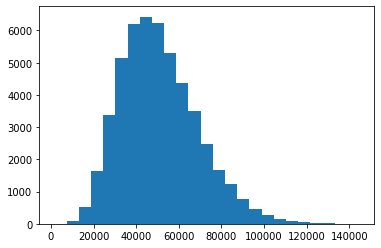

In [4]:
_ = plt.hist(x=diff_co2e, bins=25)

In [5]:
mean = np.mean(diff_co2e)
standard_deviation = np.std(diff_co2e)
print(f"Mean: {round(mean)}; standard deviation: {round(standard_deviation)}")

Mean: 50865; standard deviation: 18067


In [6]:
#TODO: Check SE-SD calculation - is the assumption about the (normal) distribution of the mean correct?